In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

In [38]:
# 词嵌入维度是512维
d_model = 512

# 词表大小是1000
vocab = 1000

# 句子最大长度
max_len=60

# 头数head
head = 8

# 词嵌入维度embedding_dim
embedding_dim = 512

# 置零比率dropout
dropout = 0.2


In [39]:
#定义Embeddings类实现文本嵌入层，复数说明有两个嵌入层，他们共享参数
class Embeddings(nn.Module):#初始化一个词嵌入模型
    def __init__(self,d_model,vocab):
        """类的初始化函数有两个参数，d_model指词嵌入的维度，vocab指词表大小"""
        #super指明继承nn.Module的初始化函数
        super(Embeddings,self).__init__()
        #调用nn预定义层Embedding，获得一个词嵌入对象self.lut
        self.lut=nn.Embedding(vocab,d_model)#将输入张量进行词嵌入的模块，参数为输入词数，词嵌入维数
        #最后将d_model传入类中
        self.d_model=d_model
        
    def forward(self,x):
        return self.lut(x)*math.sqrt(self.d_model)#？

In [40]:
# 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))

emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:", embr)


embr: tensor([[[-42.8450,  31.3230,  11.1685,  ...,  12.5626,  10.6787, -21.7877],
         [ 43.9828,   2.1781, -21.7961,  ...,   6.5700, -20.5657,  26.8288],
         [-24.4344,  21.6268,  -8.7114,  ...,  -6.6524, -11.0506,  48.4918],
         [ 29.1156,  10.6097, -20.6904,  ...,  43.8530,   2.9298,  22.5286]],

        [[-18.5331, -44.1924,  39.8537,  ..., -26.0954, -12.9191,   3.4256],
         [  5.6445, -49.4252,  -7.8111,  ...,  28.7525,  16.6465,  -2.8620],
         [ 12.2925,   4.3475, -57.0371,  ...,  25.6427,  -3.7856,  20.8581],
         [-10.6757,   5.0291,  23.1933,  ...,  37.2130,  15.9560,   7.1834]]],
       grad_fn=<MulBackward0>)


In [41]:
#位置编码器
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        #d_model词嵌入维度，max_len输入句子的最大长度
        super(PositionalEncoding,self).__init__()
        
        self.dropout=nn.Dropout(p=dropout)
        #初始化位置编码矩阵
        pe=torch.zeros(max_len,d_model)#此时pe为二维张量
        
        #position为一个绝对位置矩阵
        #arange函数用于生成一个指定起终点的序列
        position=torch.arange(0,max_len).unsqueeze(1)#对第1维进行unsqueeze，将序列中的每个值扩充为一个维
                                                     #此时position的维度为1*max_len*1
        #扩充绝对位置矩阵的维度并且经过正余弦编码？
        div_term=torch.exp(torch.arange(0,d_model,2)*#从0到d_model，并且步长为2的序列
                          -(math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)#对偶数维的
        pe[:,1::2]=torch.cos(position*div_term)#1::2表示从1开始，步长为2取元素,因此表示取所有奇数
        
        pe=pe.unsqueeze(0)#对第0维进行扩充，也就是batch后面会新增一个维度
        
        #将pe矩阵注册成为模型的buffer？使其不被优化和更新
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        #Variable用于封装张量，使之包含梯度信息
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)

In [42]:
x = embr
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
print("pe_result:", pe_result)


pe_result: tensor([[[-53.5563,  40.4037,  13.9607,  ...,  16.9533,   0.0000, -25.9846],
         [ 56.0304,   0.0000,  -0.0000,  ...,   9.4625, -25.7069,  34.7859],
         [-29.4064,   0.0000,  -0.0000,  ...,  -7.0654, -13.8130,  61.8648],
         [  0.0000,  12.0246, -25.5567,  ...,  56.0662,   3.6626,  29.4107]],

        [[-23.1663, -53.9904,  49.8172,  ..., -31.3693, -16.1488,   0.0000],
         [  8.1074, -61.1061,  -8.7366,  ...,  37.1907,   0.0000,  -2.3276],
         [ 16.5022,   4.9141, -70.1259,  ...,  33.3033,  -4.7317,  27.3226],
         [-13.1683,   5.0488,  29.2980,  ...,  47.7662,  19.9454,  10.2292]]],
       grad_fn=<MulBackward0>)


In [43]:
x=torch.randn(1,2,8,8)
y=x.view(1,-1,2,2)
y.size()

torch.Size([1, 32, 2, 2])

In [44]:
def attention(query,key,value,mask=None,dropout=None):
    #此时传入的dropout为一个模块，不是一个数
    d_k=query.size(-1)#取Q矩阵的最后一维，即词嵌入维度
    #transpose(-2,-1)为倒数第一维和倒数第二维的转置
    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)#除以缩放系数?
    
    if mask is not None:
        #调用torch中的masked_fill函数
        scores=scores.masked_fill(mask==0,-1e9)#意思是，在scores中对应元素为mask=0的都会由-1e9替换
                                               #masked_fill为torch中的函数
        
    p_attn=F.softmax(scores,dim=-1)
    
    if dropout is not None:
        p_attn=dropout(p_attn)
        
    return torch.matmul(p_attn,value),p_attn

def clone(module,N):
    """
    clone函数用于copy多头注意力机制中结构相同的线性层
    module为复制的网络模块，N为复制n份
    复制后，每个module都成为独立的层
    """
    #复制后存放于列表中
    #返回数据为一个列表，内含模块
    #ModuleList传参是个列表，deepcopy的返回值为模型
    return nn.ModuleList([copy.deepcopy(module)for _ in range(N)])

class MultiHeadAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        #head是头数
        super(MultiHeadAttention,self).__init__()
        
        #判断维数是否能被头数整除，因为之后要将维数平分给每个头
        #要为每个头等量分配词的维度特征
        assert embedding_dim%head==0
        
        #每个头分到的维度
        self.d_k=embedding_dim//head
        self.head=head
        
        #QKV各一个线性层，最后输出注意力张量的时候还需要一个线性层，总共4个线性层
        self.linears=clone(nn.Linear(embedding_dim,embedding_dim),4)#该线性层并不改变输入输出维数，需要复制四份
        #注意力张量，现在还未得到，所以为None
        self.attn=None
        
        self.dropout=nn.Dropout(p=dropout)
        
    def forward(self,query,key,value,mask=None):
        
        if mask is not None:
            mask=mask.unsqueeze(0)
            
        #batch_size是query尺寸的第0维的数字
        batch_size=query.size(0)
        
        #这个语句的功能就是：先将线性层与qkv矩阵一一匹配，再以model和x接住返回的线性层和qkv矩阵，并且用model对x进行运算
        #为什么view的后两维是head和词嵌入维度呢
        #为什么是对1，2维进行转置呢
        query,key,value=\
        [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2)#-1代表自适应，view为重塑函数
         for model,x in zip(self.linears,(query,key,value))]#用zip函数一一匹配模型和输入
                                                           #zip函数的匹配输出遵循木桶原理，与最短序列的长度相同
                                                           #因此就算linear是由4个线性层组成的列表，对应3个输入qkv也没事
        
        #print(query.size())
        x,self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)#attention会返回一个已经与v矩阵相乘后的注意力矩阵与注意力矩阵
        
        x=x.transpose(1,2).contiguous().view(batch_size,-1,self.head*self.d_k)
        """
        torch.contiguous()方法语义上是“连续的”，经常与torch.permute()、torch.transpose()、torch.view()方法一起使用，要理解这样使用的缘由，得从pytorch多维数组的低层存储开始说起：
        touch.view()方法对张量改变“形状”其实并没有改变张量在内存中真正的形状，可以理解为：

            1.view方法没有拷贝新的张量，没有开辟新内存，与原张量共享内存；
            2.view方法只是重新定义了访问张量的规则，使得取出的张量按照我们希望的形状展现。

        """
        
        #最后使用线性层列表中的最后一个线性层对输入进行线性变换得到注意力输出
        return self.linears[-1](x)
        

In [45]:
# 我们令输入的query, key, value都相同, 位置编码的输出
query = key = value = pe_result

attn, p_attn = attention(query, key, value)
print("attn:", attn)
print("p_attn:", p_attn)


attn: tensor([[[-53.5563,  40.4037,  13.9607,  ...,  16.9533,   0.0000, -25.9846],
         [ 56.0304,   0.0000,   0.0000,  ...,   9.4625, -25.7069,  34.7859],
         [-29.4064,   0.0000,   0.0000,  ...,  -7.0654, -13.8130,  61.8648],
         [  0.0000,  12.0246, -25.5567,  ...,  56.0662,   3.6626,  29.4107]],

        [[-23.1663, -53.9904,  49.8172,  ..., -31.3693, -16.1488,   0.0000],
         [  8.1074, -61.1061,  -8.7366,  ...,  37.1907,   0.0000,  -2.3276],
         [ 16.5022,   4.9141, -70.1259,  ...,  33.3033,  -4.7317,  27.3226],
         [-13.1683,   5.0488,  29.2980,  ...,  47.7662,  19.9454,  10.2292]]],
       grad_fn=<UnsafeViewBackward0>)
p_attn: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


In [46]:
# 假设输入的Q，K，V仍然相等
query = value = key = pe_result

# 输入的掩码张量mask
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)


tensor([[[ -8.6024,   1.4997,  -0.3741,  ...,  -8.6160,  -4.9846,  10.0918],
         [ -8.1386,   0.7334,  -0.8478,  ...,  -5.1665,  -3.2912,   6.0987],
         [-12.6593,   2.6060,  -3.3428,  ...,  -5.6440,  -2.8931,  10.8317],
         [-10.8656,   1.2189,  -6.4823,  ...,  -6.4340,  -1.9653,  11.1541]],

        [[  2.0292,  -0.8085,  -6.7050,  ...,  -0.6295,   3.3251,  -2.7522],
         [  3.8116,   0.2475,  -6.4386,  ...,   5.5348,  -2.0732,  -3.6453],
         [  5.9205,  -1.8495,  -3.4533,  ...,   2.8770,  -1.1310,   0.6678],
         [  4.7254,  -2.3016,  -2.1329,  ...,   6.4289,  -2.3864,   3.4357]]],
       grad_fn=<ViewBackward0>)


In [47]:
query = key = value = pe_result

# 令mask为一个2x4x4的零张量
mask = Variable(torch.zeros(2, 4, 4))
attn, p_attn = attention(query, key, value, mask=mask)
print("attn:", attn)
print("p_attn:", p_attn)


attn: tensor([[[ -6.7331,  13.1071,  -2.8990,  ...,  18.8542,  -8.9643,  25.0192],
         [ -6.7331,  13.1071,  -2.8990,  ...,  18.8542,  -8.9643,  25.0192],
         [ -6.7331,  13.1071,  -2.8990,  ...,  18.8542,  -8.9643,  25.0192],
         [ -6.7331,  13.1071,  -2.8990,  ...,  18.8542,  -8.9643,  25.0192]],

        [[ -2.9312, -26.2834,   0.0632,  ...,  21.7227,  -0.2338,   8.8061],
         [ -2.9312, -26.2834,   0.0632,  ...,  21.7227,  -0.2338,   8.8061],
         [ -2.9312, -26.2834,   0.0632,  ...,  21.7227,  -0.2338,   8.8061],
         [ -2.9312, -26.2834,   0.0632,  ...,  21.7227,  -0.2338,   8.8061]]],
       grad_fn=<UnsafeViewBackward0>)
p_attn: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500,

In [48]:
#即残差模块
class SublayerConnection(nn.Module):
    def __init__(self,d_model,dropout=0.1):
        #size为词嵌入维度
        super(SublayerConnection,self).__init__()
        
        self.norm=LayerNorm(d_model)
        self.dropout=nn.Dropout(p=dropout)
        
    #这里可能是一个递归调用，x为残差连接，sublayer为经过的正则化dropout层
    def forward(self,x,sublayer):#这里传入的sublayer为任意功能的层（如自注意力层，多头注意力层等）
        #残差模块
        return x+self.dropout(sublayer(self.norm(x)))
    #输出为sc_result
    
    #正则化层
class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        """
        features为词嵌入维度，eps为一个较小的数，防止除零错
        """
        super(LayerNorm,self).__init__()
        """
        nn.Parameter可以看作是一个类型转换函数，将一个不可训练的类型 Tensor 转换成可以训练的类型 parameter ，
        并将这个 parameter 绑定到这个module 里面(net.parameter() 中就有这个绑定的 parameter，所以在参数优化的时候可以进行优化)，
        所以经过类型转换这个变量就变成了模型的一部分，成为了模型中根据训练可以改动的参数。
        使用这个函数的目的也是想让某些变量在学习的过程中不断的修改其值以达到最优化。

        """
        self.a2=nn.Parameter(torch.ones(features))#a2是缩放参数，b2是位移参数？
        self.b2=nn.Parameter(torch.zeros(features))
        
        self.eps=eps
        
    def forward(self,x):
        
        mean=x.mean(-1,keepdim=True)#表示对倒数第一维求均值，keepdim表示输出的维度与输入一致
        std=x.std(-1,keepdim=True)
        return self.a2*(x-mean)/(std+self.eps)+self.b2
    
    #输出为ln_result
    

In [49]:
# 令x为位置编码器的输出
x = pe_result
mask = Variable(torch.zeros(8, 4, 4))

# 假设子层中装的是多头注意力层, 实例化这个类
self_attn =  MultiHeadAttention(head, d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x: self_attn(x, x, x, mask)#lambda表达式，冒号前的是参数，冒号后的是返回值

In [50]:
#并不是递归调用，仅仅是残差模块而已
sc = SublayerConnection(d_model, dropout)
sc_result = sc(x, sublayer)#forward函数可以传入内部参数以外的参数
print(sc_result)
print(sc_result.shape)

tensor([[[-5.3778e+01,  4.0244e+01,  1.3719e+01,  ...,  1.7148e+01,
          -1.6384e-01, -2.6239e+01],
         [ 5.5850e+01, -1.2291e-01, -0.0000e+00,  ...,  9.6337e+00,
          -2.5707e+01,  3.4461e+01],
         [-2.9712e+01, -1.6220e-01, -0.0000e+00,  ..., -6.8828e+00,
          -1.3874e+01,  6.1561e+01],
         [-2.7440e-01,  1.1907e+01, -2.5726e+01,  ...,  5.6066e+01,
           3.5179e+00,  2.9411e+01]],

        [[-2.3125e+01, -5.4058e+01,  4.9817e+01,  ..., -3.1369e+01,
          -1.6149e+01,  1.5993e-01],
         [ 8.2255e+00, -6.1257e+01, -8.7849e+00,  ...,  3.7502e+01,
           6.0727e-03, -2.3276e+00],
         [ 1.6517e+01,  4.8644e+00, -7.0088e+01,  ...,  3.3513e+01,
          -4.4587e+00,  2.7471e+01],
         [-1.3167e+01,  5.0141e+00,  2.9484e+01,  ...,  4.8046e+01,
           1.9967e+01,  1.0423e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [51]:
#全连接层
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        """
        d_ff为第二个线性层输入的维度，即中间的维度，
        """
        super(PositionwiseFeedForward,self).__init__()
        
        #可以看到输入输出维度并不会改变，只有中间层维度会变化
        self.w1=nn.Linear(d_model,d_ff)
        self.w2=nn.Linear(d_ff,d_model)
        
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        return self.w2(self.dropout(F.relu(self.w1(x))))
    
    #输出为ff_result

In [52]:
d_ff=64

ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)


tensor([[[ -8.0158,  19.7300, -13.9961,  ...,  20.3899,  -9.0827,  -6.7726],
         [  7.4217,  11.5559,   5.7475,  ...,  -1.5096,  -9.5374,  -1.3504],
         [  8.7671,  12.6318,  -7.0152,  ...,   1.5300,  -7.4479,  -3.2946],
         [ -5.1819,   7.0179,  -5.3566,  ...,   3.1291, -19.3869,  -9.0870]],

        [[-12.7654,  19.6663,   3.5488,  ...,   5.8255,  -3.1913,   2.3634],
         [  1.6226,  13.4079,   0.5275,  ...,  -5.3399,  -7.7279,  -4.6860],
         [ -3.4155,  11.1574, -10.9698,  ...,   2.8705,  -9.4404,   2.5980],
         [  0.7116,   3.8811, -10.2604,  ...,   2.6580,  -7.5809,  -7.7203]]],
       grad_fn=<ViewBackward0>)


# 编码器层结构

- 请对照结构图解读以下代码

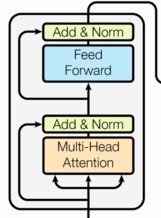

In [53]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        """
        分别输入词嵌入维度，自注意力模块对象，全连接网络，dropout
        """
        super(EncoderLayer,self).__init__()
        
        self.self_attn=self_attn
        self.feed_forward=feed_forward
        
        #别忘了clone返回值为列表
        self.sublayer=clone(SublayerConnection(size,dropout),2)#如图，需要两个sublayer
        self.size=size
        
    def forward(self,x,mask):
        """
        x为上一层输出，mask为掩码张量
        """
        #clone返回值为列表
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)
    #输出为el_result
    

In [54]:
el = EncoderLayer(d_model, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)


tensor([[[-54.1817,  41.1360,  12.5715,  ...,  18.0370,  -0.2412, -26.3332],
         [ 55.9590,   0.3395,  -0.3324,  ...,  10.1314, -25.9402,  34.4558],
         [-29.5856,   0.1432,  -0.7273,  ...,  -6.5551, -14.3870,  61.8417],
         [ -0.5713,  12.3055, -25.9024,  ...,  56.3248,   2.7548,  28.6888]],

        [[-23.4845, -53.3674,  49.8382,  ..., -30.5685, -16.2418,   0.2047],
         [  8.1527, -60.7127,  -8.6052,  ...,  37.3205,   0.1959,  -2.4134],
         [ 16.4541,   5.3017, -70.5950,  ...,  33.6983,  -5.0648,  27.3362],
         [-13.1147,   4.9611,  28.7053,  ...,  48.4791,  20.0713,  10.3997]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [55]:
class Encoder(nn.Module):
    def __init__(self,layer,N):
        """
        传入编码器层对象，以及要复制几份，即有几层编码器
        """
        super(Encoder,self).__init__()
        
        self.layers=clone(layer,N)#layers为列表
        self.norm=LayerNorm(layer.size)
        
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

In [56]:
# 第一个实例化参数layer, 它是一个编码器层的实例化对象, 因此需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.

c = copy.deepcopy
attn = MultiHeadAttention(head, d_model)
#ff = PositionwiseFeedForward(d_model, d_ff, dropout)

layer = EncoderLayer(d_model, c(attn), c(ff), dropout)

# 编码器中编码器层的个数N
N = 8
mask = Variable(torch.zeros(8, 4, 4))


en = Encoder(layer, N)
en_result = en(x, mask)
print(en_result)
print(en_result.shape)


tensor([[[-2.2108,  1.6363,  0.3048,  ...,  0.7496, -0.0182, -1.0505],
         [ 2.2020,  0.0807,  0.0391,  ...,  0.4636, -0.9676,  1.4326],
         [-1.2072,  0.0478, -0.1285,  ..., -0.3113, -0.5763,  2.3813],
         [-0.1576,  0.5107, -1.1163,  ...,  2.1651, -0.0262,  1.0796]],

        [[-0.8943, -1.9799,  1.8762,  ..., -1.1014, -0.6765,  0.0200],
         [ 0.3505, -2.4036, -0.4923,  ...,  1.2988, -0.2113, -0.2721],
         [ 0.6581,  0.2663, -2.8257,  ...,  1.3192, -0.2621,  1.0869],
         [-0.5164,  0.2157,  0.9555,  ...,  1.9622,  0.6683,  0.3311]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# 解码器层的结构
- 对照结构图解析以下代码

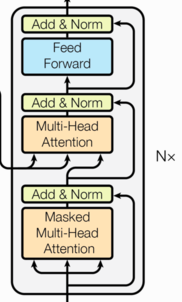

In [57]:
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        
        """
        size嵌入维度，
        self_attn多头注意力对象,Q=K=V
        src_attn交叉注意力对象此处Q与K，V不相等
        feed_forward全连接层对象
        """
        
        super(DecoderLayer,self).__init__()
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn#cross attention模块
        self.feed_forward=feed_forward
        
        self.sublayer=clone(SublayerConnection(size,dropout),3)#需要三个残差模块
        
    def forward(self,x,memory,source_mask,target_mask):
        """
        memory为cross attention模块传入的encoder层的结果
        
        """
        m=memory
        
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,target_mask))

        x=self.sublayer[1](x,lambda x:self.src_attn(x,m,m,source_mask))
        
        return self.sublayer[2](x,self.feed_forward)

In [58]:
# x是来自目标数据的词嵌入表示, 但形式和源数据的词嵌入表示相同, 这里使用per充当.
x = pe_result

# memory是来自编码器的输出
memory = en_result

# 实际中source_mask和target_mask并不相同, 这里为了方便计算使他们都为mask
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask


In [59]:
class Decoder(nn.Module):
    def __init__(self,layer,N):
        """
        layer为传入的Decoder层，
        N为需要构造N层
        """
        super(Decoder,self).__init__()
        
        self.layers=clone(layer,N)
        
        self.norm=LayerNorm(layer.size)
        
    def forward(self,x,memory,source_mask,target_mask):
        """
        
        """
        
        for layer in self.layers:#遍历装有layer的列表
            x=layer(x,memory,source_mask,target_mask)
        return self.norm(x)

In [60]:
# 输入参数与解码器层的输入参数相同
c = copy.deepcopy
attn = MultiHeadAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
x = pe_result
memory = en_result
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask


In [61]:
de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(de_result)
print(de_result.shape)


tensor([[[-2.0838,  1.5099,  0.4080,  ...,  0.5821, -0.1956, -1.1746],
         [ 2.1401,  0.0250, -0.1895,  ...,  0.4224, -1.1238,  1.3864],
         [-1.3191, -0.1210, -0.3338,  ..., -0.3423, -0.7303,  2.3523],
         [-0.0201,  0.3358, -1.3090,  ...,  2.1822, -0.0659,  0.9445]],

        [[-0.7505, -2.3944,  2.0905,  ..., -1.0678, -0.6980, -0.1428],
         [ 0.2960, -2.6209, -0.3530,  ...,  1.3714,  0.0205, -0.0939],
         [ 0.6778,  0.1200, -2.5313,  ...,  1.2966, -0.2744,  0.9657],
         [-0.5547,  0.0463,  1.4173,  ...,  2.1009,  0.6780,  0.2874]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [62]:
class Generator(nn.Module):
    def __init__(self,d_model,vocab_size):
        """
        词嵌入维度和词表大小
        """
        super(Generator,self).__init__()
        
        self.project=nn.Linear(d_model,vocab_size)#？
        
    def forward(self,x):
        """
        log_softmax是对softmax的结果取对数
        """
        return F.log_softmax(self.project(x),dim=-1)

In [63]:
# 输入x是上一层网络的输出, 我们使用来自解码器层的输出
x = de_result

gen = Generator(d_model, vocab)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)


tensor([[[-7.0183, -7.1302, -6.6815,  ..., -6.7693, -7.8151, -7.7854],
         [-6.7569, -7.2665, -7.5841,  ..., -6.4439, -7.9734, -7.6022],
         [-6.7100, -6.1290, -6.3257,  ..., -7.9135, -7.0350, -6.6711],
         [-7.2700, -8.3423, -8.0057,  ..., -6.3396, -7.4684, -8.1201]],

        [[-8.1833, -7.0140, -7.0721,  ..., -7.2879, -7.2328, -7.0938],
         [-6.9180, -7.5397, -6.2129,  ..., -7.4191, -7.2246, -7.4946],
         [-8.0114, -6.3292, -7.3219,  ..., -7.3766, -6.7534, -7.1387],
         [-7.4050, -6.8172, -7.2076,  ..., -7.3049, -7.1891, -6.1970]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 4, 1000])


In [64]:
class EncoderDecoder(nn.Module):
    """
    初始化函数中的5个参数，为编码器对象，解码器对象，源数据嵌入函数，目标数据嵌入函数，以及输出部分的生成器对象
    """
    def __init__(self,encoder,decoder,source_embed,target_embed,generator):
        super(EncoderDecoder,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=source_embed#例如英译中任务，英文的词嵌入即源数据词嵌入
        self.tgt_embed=target_embed#中文的词嵌入即目标数词嵌入
        self.generator=generator
        
    def forward(self,source,target,source_mask,target_mask):
        """
        四个输入参数分别为源数据，目标数据，以及两者对应的掩码张量
        """
        #decoder的传参：x,memory,source_mask,target_mask
        #
        return self.decode(self.encode(source,source_mask),source_mask,target,target_mask)
    
    #写在类中的函数调用的时候要加self
    def encode(self,source,source_mask):
        #src_embed做词嵌入
        return self.encoder(self.src_embed(source),source_mask)
    
    def decode(self,memory,source_mask,target,target_mask):
        """解码函数，memory为编码器输出"""
        return self.decoder(self.tgt_embed(target),memory,source_mask,target_mask)
        

In [65]:
# 假设源数据与目标数据相同, 实际中并不相同
source = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))

# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = Variable(torch.zeros(8, 4, 4))

source_embed = nn.Embedding(vocab, d_model)
target_embed = nn.Embedding(vocab, d_model)

#调用整个模型需要编码器，解码器，源数据与目标数据各一个词嵌入器，以及一个生成器（输出）
ed = EncoderDecoder(en, de, source_embed, target_embed, gen)
#模型的前向传播需要输入源和目标数据，以及其对应的掩码张量
ed_result = ed(source, target, source_mask, target_mask)
print(ed_result)
print(ed_result.shape)


tensor([[[ 3.6950e-01,  9.0281e-01, -1.3171e+00,  ...,  1.4403e+00,
           6.9781e-01,  8.3487e-01],
         [-6.5822e-01,  7.6649e-01, -4.1609e-01,  ...,  3.0720e-01,
          -6.6800e-01,  6.3013e-01],
         [ 9.5553e-04,  1.0772e+00, -3.3781e-01,  ...,  6.6893e-01,
          -8.1122e-01,  4.6226e-01],
         [ 2.0827e-02,  1.8518e+00, -1.3018e-01,  ...,  9.9343e-01,
           3.4457e-01,  1.0662e+00]],

        [[ 7.9347e-01, -1.2197e+00,  7.7637e-01,  ...,  6.5075e-01,
          -1.2625e+00, -8.5776e-02],
         [ 1.6196e-01, -1.3515e+00,  8.3968e-01,  ...,  1.3574e+00,
          -1.4666e+00, -1.0641e-01],
         [ 7.3058e-01, -7.7232e-01,  4.1972e-02,  ...,  7.0280e-01,
          -1.1227e+00,  3.7785e-01],
         [ 1.1727e+00, -6.0379e-01,  6.3217e-01,  ...,  8.4493e-01,
          -8.7514e-01,  8.0578e-02]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [66]:
def make_model(source_vocab,target_vocab,N=6,d_model=512,d_ff=2048,head=8,dropout=0.1):
    """
    用于构建模型的函数，
    所有超参数分别是源数据词汇数，目标数据词汇数，编码器和解码器堆叠层数，词向量映射维度，FC隐藏层维度
    """
    #深度拷贝，防止复制出来的两个部分拥有相同的内存地址
    c=copy.deepcopy#c是一个函数类，起的作用相当于对这个函数重命名
    
    attn=MultiHeadAttention(head,d_model)
    
    ff=PositionwiseFeedForward(d_model,d_ff,dropout)
    
    position=PositionalEncoding(d_model,dropout)
    
    #EncoderDecoder的五个参数：encoder,decoder,source_embed,target_embed,generator
    model=EncoderDecoder(
        #
        Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
        
        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
        
        nn.Sequential(Embeddings(d_model,source_vocab),c(position)),
        
        nn.Sequential(Embeddings(d_model,target_vocab),c(position)),
        
        Generator(d_model,target_vocab))
    
    #以上为模型构建，接下来是初始化模型参数，服从Xavier分布
    for p in model.parameters():
        if p.dim()>1:#若参数维度大于1，则初始化一个服从Xavier分布的矩阵
            nn.init.xavier_uniform_(p)
    
    return model

In [67]:
if __name__ == '__main__':
    res = make_model(vocab, vocab, N)
    print(res)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

**关于generator类的补充说明：**
- 生成器函数，当系统判定函数中有yield这种返回函数时，就会将函数判断为生成器函数
- 调用生成器函数时，返回的值为一个生成器对象
- yield返回值时，并不会造成函数退出执行（不会像return一样），函数会处于一种类似按下了暂停键的状态，下次重新执行时，会接着执行

In [68]:
#copy任务对模型进行测试
#copy任务，即“鹦鹉学舌”，常用于检测模型整体的运行情况

# 导入工具包Batch, 它能够对原始样本数据生成对应批次的掩码张量
from pyitcast.transformer_utils import Batch  

def data_generator(V, batch, num_batch):
    """
    该函数用于随机生成copy任务的数据, 它的三个输入参数是V: 随机生成数字的最大值+1, 
    batch: 每次输送给模型更新一次参数的数据量, num_batch: 一共输送num_batch次完成一轮
    """
    # 使用for循环遍历nbatches
    for i in range(num_batch):
        
        # 在循环中使用np的random.randint方法随机生成[1, V)的整数, 
        # 分布在(batch, 10)形状的矩阵中, 然后再把numpy形式转换称torch中的tensor.
        
        #size=(batch,10)表示放在batch*10大小的矩阵中
        #1,V表示生成从1到V范围内的随机数
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10),dtype='int64'))#就是torch.from_numpy()方法把数组转换成张量，
                                                                                        #且二者共享内存，对张量进行修改比如重新赋值，
                                                                                        #那么原始数组也会相应发生改变。
                                                                                        #这里的int64的参数非常重要，没有这个，训练时新版torch会报错
        #print(data.size())
        data.unsqueeze(0)
        # 接着使数据矩阵中的第一列数字都为1, 这一列也就成为了起始标志列, 
        # 当解码器进行第一次解码的时候, 会使用起始标志列作为输入.
        data[:, 0] = 1#data此时的数据类型为张量

        # 因为是copy任务, 所有source与target是完全相同的, 且数据样本作用变量不需要求梯度
        # 因此requires_grad设置为False
        source = Variable(data, requires_grad=False)
        target = Variable(data, requires_grad=False)
        
        #Batch是一个data generator对象(生成器对象)
        #print(type(Batch(source,target)))
        #使用Batch对source和target进行对应批次的掩码张量生成, 最后使用yield返回
        yield Batch(source, target) #yield也是一种返回值的方法,就像return一样


In [69]:
# 将生成0-10的整数
V = 11

# 每次喂给模型20个数据进行参数更新
batch = 20 

# 连续喂30次完成全部数据的遍历, 也就是1轮
num_batch = 30

if __name__ == '__main__':
    res = data_generator(V, batch, num_batch)
    print(res)


<generator object data_generator at 0x000001942E25A960>


- 标签平滑：
https://blog.csdn.net/qq_41915623/article/details/124852409

In [70]:
#标签平滑，其原理类似于我们在学习贝叶斯机器学习时用的拉普拉斯平滑，本质是为了避免0带来的数据丢失的影响

# 导入优化器工具包get_std_opt, 该工具用于获得标准的针对Transformer模型的优化器 
# 该标准优化器基于Adam优化器, 使其对seq2seq的任务更有效.
from pyitcast.transformer_utils import get_std_opt

# 导入标签平滑工具包, 该工具用于标签平滑
# 因为在理论上即使是人工的标注数据也可能并非完全正确, 
# 会受到一些外界因素的影响而产生一些微小的偏差（去掉one-hot编码带来的绝对性？）
# 在去除标签绝对性这一点上，可能贝叶斯派比频率派做的更好
# 因此使用标签平滑来弥补这种偏差, 减少模型对某一条规律的绝对认知, 以防止过拟合. 通过下面示例了解更多.
from pyitcast.transformer_utils import LabelSmoothing

# 导入损失计算工具包, 该工具能够使用标签平滑后的结果进行损失的计算, 
# 损失的计算方法可以认为是交叉熵损失函数.
from pyitcast.transformer_utils import SimpleLossCompute

# 使用make_model获得model
model = make_model(V, V, N=2)#N为编解码器堆叠层数

# 使用get_std_opt获得模型优化器
model_optimizer = get_std_opt(model)

# 使用LabelSmoothing获得标签平滑对象
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)#标签平滑也相当于一个损失函数，

# 使用SimpleLossCompute获得利用标签平滑结果的损失计算方法
loss = SimpleLossCompute(model.generator, criterion, model_optimizer)


 **标签平滑图像分析:**

   - 我们目光集中在黄色小方块上, 它相对于横坐标横跨的值域就是标签平滑后的正向平滑值域, 我们可以看到大致是从0.5到2.5.
   - 它相对于纵坐标横跨的值域就是标签平滑后的负向平滑值域, 我们可以看到大致是从-0.5到1.5, 总的值域空间由原来的[0, 2]变成了[-0.5, 2.5].


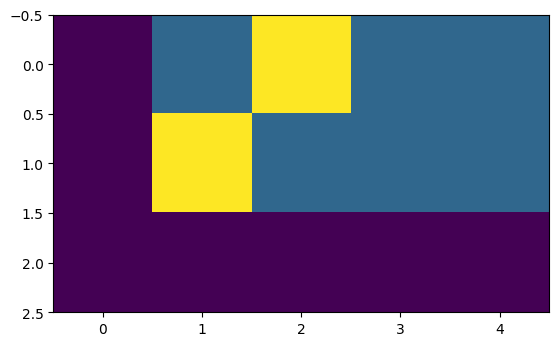

In [71]:
from pyitcast.transformer_utils import LabelSmoothing

# 使用LabelSmoothing实例化一个crit对象.
# 第一个参数size代表目标数据的词汇总数, 也是模型最后一层得到张量的最后一维大小
# 这里是5说明目标词汇总数是5个. 第二个参数padding_idx表示要将那些tensor中的数字
# 替换成0, 一般padding_idx=0表示不进行替换. 第三个参数smoothing, 表示标签的平滑程度
# 如原来标签的表示值为1, 则平滑后它的值域变为[1-smoothing, 1+smoothing].
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.5)

# 假定一个任意的模型最后输出预测结果和真实结果
predict = Variable(torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]]))

# 标签的表示值是0，1，2
target = Variable(torch.LongTensor([2, 1, 0]))

# 将predict, target传入到对象中
crit(predict, target)

# 绘制标签平滑图像
plt.imshow(crit.true_dist)


In [72]:
# 导入模型单轮训练工具包run_epoch, 该工具将对模型使用给定的损失函数计算方法进行单轮参数更新.
# 并打印每轮参数更新的损失结果.
from pyitcast.transformer_utils import run_epoch

def run(model, loss, epochs=10):
    """模型训练函数, 共有三个参数, model代表将要进行训练的模型
       loss代表使用的损失计算方法, epochs代表模型训练的轮数"""

    # 遍历轮数
    for epoch in range(epochs):
        # 模型使用训练模式, 所有参数将被更新
        model.train()
        # 训练时, batch_size是20
        run_epoch(data_generator(V, 8, 20), model, loss)

        # 模型使用评估模式, 参数将不会变化 
        model.eval()
        # 评估时, batch_size是5，batch是8
        run_epoch(data_generator(V, 8, 5), model, loss)
        
if __name__ =='__main__':
    run(model,loss)


Epoch Step: 1 Loss: 3.250586 Tokens per Sec: 268.257324
Epoch Step: 1 Loss: 2.673045 Tokens per Sec: 347.154724
Epoch Step: 1 Loss: 2.952479 Tokens per Sec: 345.528351
Epoch Step: 1 Loss: 2.208657 Tokens per Sec: 363.832947
Epoch Step: 1 Loss: 2.342146 Tokens per Sec: 343.917755
Epoch Step: 1 Loss: 1.923403 Tokens per Sec: 315.662811
Epoch Step: 1 Loss: 2.084710 Tokens per Sec: 328.445709
Epoch Step: 1 Loss: 1.780697 Tokens per Sec: 362.795715
Epoch Step: 1 Loss: 2.039133 Tokens per Sec: 333.377380
Epoch Step: 1 Loss: 1.682975 Tokens per Sec: 353.778046
Epoch Step: 1 Loss: 1.876048 Tokens per Sec: 343.118073
Epoch Step: 1 Loss: 1.551792 Tokens per Sec: 340.649719
Epoch Step: 1 Loss: 2.004401 Tokens per Sec: 344.246674
Epoch Step: 1 Loss: 1.602941 Tokens per Sec: 386.177795
Epoch Step: 1 Loss: 1.805376 Tokens per Sec: 355.518738
Epoch Step: 1 Loss: 1.422719 Tokens per Sec: 357.204834
Epoch Step: 1 Loss: 1.768822 Tokens per Sec: 365.200409
Epoch Step: 1 Loss: 1.214368 Tokens per Sec: 322

In [73]:
# 进行10轮训练
epochs = 10

# model和loss都是来自上一步的结果


In [74]:
# 导入贪婪解码工具包greedy_decode, 该工具将对最终结进行贪婪解码
# 贪婪解码的方式是每次预测都选择概率最大的结果作为输出, 
# 它不一定能获得全局最优性, 但却拥有最高的执行效率.
from pyitcast.transformer_utils import greedy_decode 


def run(model, loss, epochs=10):
    for epoch in range(epochs):
        model.train()

        run_epoch(data_generator(V, 8, 20), model, loss)

        model.eval()

        run_epoch(data_generator(V, 8, 5), model, loss)

    # 模型进入测试模式
    model.eval()

    # 假定的输入张量
    source = Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

    # 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
    # 因此相当于对源数据没有任何遮掩.
    source_mask = Variable(torch.ones(1, 1, 10))

    # 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
    # 以及起始标志数字, 默认为1, 我们这里使用的也是1
    result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
    print(result)


if __name__ == '__main__':
    run(model, loss) 


Epoch Step: 1 Loss: 1.507469 Tokens per Sec: 364.298828
Epoch Step: 1 Loss: 1.014847 Tokens per Sec: 350.637299
Epoch Step: 1 Loss: 1.207305 Tokens per Sec: 346.371521
Epoch Step: 1 Loss: 0.832669 Tokens per Sec: 354.665100
Epoch Step: 1 Loss: 1.282969 Tokens per Sec: 333.407745
Epoch Step: 1 Loss: 0.789546 Tokens per Sec: 365.752869
Epoch Step: 1 Loss: 0.987456 Tokens per Sec: 381.241150
Epoch Step: 1 Loss: 0.789522 Tokens per Sec: 355.520203
Epoch Step: 1 Loss: 1.194777 Tokens per Sec: 324.265656
Epoch Step: 1 Loss: 0.411088 Tokens per Sec: 339.083405
Epoch Step: 1 Loss: 0.740552 Tokens per Sec: 328.630829
Epoch Step: 1 Loss: 0.418721 Tokens per Sec: 387.195557
Epoch Step: 1 Loss: 0.735511 Tokens per Sec: 344.296722
Epoch Step: 1 Loss: 0.411846 Tokens per Sec: 382.966644
Epoch Step: 1 Loss: 0.596176 Tokens per Sec: 362.460876
Epoch Step: 1 Loss: 0.502780 Tokens per Sec: 350.412933
Epoch Step: 1 Loss: 0.507656 Tokens per Sec: 342.249176
Epoch Step: 1 Loss: 0.311049 Tokens per Sec: 382

结果完全正确！完工！